#Loica and Flapjack setup

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
% cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [3]:
% cd LOICA/

/content/gdrive/My Drive/LOICA


In [4]:
import numpy as np
import getpass
import datetime
import random as rd
import pandas as pd

from numpy.fft import fft, ifft, fftfreq
from scipy.interpolate import interp1d, UnivariateSpline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_absolute_error

from scipy.signal import savgol_filter, medfilt

import matplotlib.pyplot as plt
import seaborn as sns

color_inverse = 'dodgerblue'
color_direct = 'orangered'
color_indirect = 'gold'

hfont = {'fontname':'Helvetica'}

%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

Para figuras de 1 columna ancho maximo 3.33,  y para doble columna minimo 4.167 y maximo 7. Para ambos la maxima altura es 9.167 (inches)

#Gene expression profile

In [5]:
profile = 'gompertz'
df_characterization = pd.read_json('df_characterization_growth1.json')
df_characterization = df_characterization[df_characterization.nsr!=0.01][df_characterization['Profile']== profile]

In [6]:
df_characterization

,Profile,nsr,eps,Iteration,Method,Metric,Score,Data_true_profile,Data_method_profile
0,gompertz,0.000,0.000000,0,Indirect,MSE,0.000883,"[0.0009128047, 0.0023242143, 0.0053094605, 0.0...","[-0.0592800135, -0.035506848800000004, -0.0111..."
1,gompertz,0.000,0.000000,0,Direct,MSE,0.028990,"[0.0009128047, 0.0023242143, 0.0053094605, 0.0...","[0.4925613552, 0.4925589882, 0.492551744900000..."
2,gompertz,0.000,0.016681,0,Gaussian,MSE,0.000935,"[0.0009128047, 0.0023242143, 0.0053094605, 0.0...","[0.0320201112, 0.0433630156, 0.0576644528, 0.0..."
3,gompertz,0.000,0.000000,1,Indirect,MSE,0.000570,"[0.0020097129, 0.0043223648, 0.0085582434, 0.0...","[-0.052146386, -0.0289146557, -0.0051937311000..."
4,gompertz,0.000,0.000000,1,Direct,MSE,0.025136,"[0.0020097129, 0.0043223648, 0.0085582434, 0.0...","[0.4763400848, 0.4763381995, 0.476332394000000..."
...,...,...,...,...,...,...,...,...,...
2095,gompertz,0.001,0.000000,98,Direct,MSE,0.028616,"[0.003503103, 0.008432703, 0.0180831319, 0.035...","[0.4861847071, 0.4861802894, 0.4861707455, 0.4..."
2096,gompertz,0.001,0.016681,98,Gaussian,MSE,0.002156,"[0.003503103, 0.008432703, 0.0180831319, 0.035...","[0.0679395909, 0.0926066086, 0.1225345349, 0.1..."
2097,gompertz,0.001,0.000000,99,Indirect,MSE,0.070156,"[0.0130362432, 0.025665183100000002, 0.0462303...","[-1.1684148828, -1.2229167142, -1.1884123559, ..."
2098,gompertz,0.001,0.000000,99,Direct,MSE,0.023910,"[0.0130362432, 0.025665183100000002, 0.0462303...","[0.4703790249, 0.4703752283, 0.4703660793, 0.4..."


In [7]:
#Growth rate init
df_growth_rate = df_characterization

dir_err = []
inv_err = []
indir_err = []

ints = df_growth_rate[df_growth_rate.Metric=='MSE'].groupby('Iteration') #[df_growth_rate.nsr==0]
for _,it in ints: #que es it? sobre que esta iterando?
    true_profile = np.array(it[it.Method=='Gaussian'].Data_true_profile.values[0]) #get true profile
    true_pk = true_profile[0] #np.where(true_profile==np.max(true_profile))[0][0] #obtain value at first position or timr
    inv_profile = np.array(it[it.Method=='Gaussian'].Data_method_profile.values[0])
    inv_pk = inv_profile[0] #np.where(inv_profile==np.max(inv_profile))[0][0]
    dir_profile = np.array(it[it.Method=='Direct'].Data_method_profile.values[0])
    dir_pk = dir_profile[0] #np.where(dir_profile==np.max(dir_profile))[0][0]
    indir_profile = np.array(it[it.Method=='Indirect'].Data_method_profile.values[0])
    indir_pk = indir_profile[0] #np.where(dir_profile==np.max(dir_profile))[0][0]

    print(true_pk, inv_pk, dir_pk)
    dir_err.append(dir_pk - true_pk)
    inv_err.append(inv_pk - true_pk)
    indir_err.append(indir_pk - true_pk)

0.0009128047 0.0320201112 0.4925613552
0.0020097129 0.0339072512 0.4763400848
0.3237589387 0.2981562136 0.42388657430000004
0.0010109934 0.0333113432 0.46471424240000003
0.0016083142 0.0753750659 0.500724776
0.0011333812 0.018643675000000002 0.5067170826
0.0487502844 0.19598917400000002 0.4703239415
0.0070739492000000005 0.0312361222 0.4357462949
5.2e-09 0.0032617633 0.5217789438
0.0482945933 0.0714635104 0.43101038750000004
0.3997705864 0.4135759976 0.4387485324
0.2743575904 0.22729581140000002 0.43512223910000003
0.0067895746 0.0351614753 0.43691041410000003
0.1231510566 0.2458990295 0.4204160912
0.0004432036 0.0231323407 0.4824192483
0.1818033981 0.3054402073 0.4238935237
0.0295244136 0.0743246969 0.4280364253
0.0237496791 0.074258975 0.44864970460000003
0.011278516700000001 0.0890855451 0.46809811960000003
0.007427927700000001 0.0331647953 0.44165820710000003
1.39854e-05 0.0090451466 0.5056927613000001
0.1135184089 0.11884252690000001 0.3955949259
0.0399214507 0.0836141012 0.424400

In [8]:
df_plot = df_characterization.rename(columns={'Score': 'Error'})

In [9]:
df_plot = df_plot.assign(NRMSE=np.sqrt(df_plot.Error))

noise = np.round(100*np.sqrt(df_plot.nsr))
noise = ['%d%%'%n for n in noise]
df_plot = df_plot.assign(Noise=noise)
df_plot = df_plot[df_plot['Metric']=='MSE'] #[df_plot.nsr==1e-3]

df_plot = df_plot[df_plot['Metric']=='MSE'] #[df_plot.nsr==1e-3]
df_plot.loc[df_plot.Method=='Gaussian', 'Method'] = 'Inverse'

In [10]:
from scipy.stats import ttest_ind
for nsr,df in df_plot.groupby('nsr'):
    a = df[df.Method=='Inverse'][df.Profile==profile]
    b = df[df.Method=='Direct'][df.Profile==profile]
    c = df[df.Method=='Indirect'][df.Profile==profile]
    print('Inverse|Direct')
    print(ttest_ind(a.Error,b.Error, equal_var=False))
    print('Inverse|Indirect')
    print(ttest_ind(a.Error,c.Error, equal_var=False))
    #print(kruskal(a.Error,b.Error))
    print('Direct/Inverse')
    print(b.Error.mean()/a.Error.mean())
    print('Indirect/Inverse')
    print(c.Error.mean()/a.Error.mean())

Inverse|Direct
Ttest_indResult(statistic=-18.909840638095222, pvalue=9.804531733049345e-35)
Inverse|Indirect
Ttest_indResult(statistic=-4.094963249548138, pvalue=7.687483285155084e-05)
Direct/Inverse
29.2274578617925
Indirect/Inverse
2.0915010408152925
Inverse|Direct
Ttest_indResult(statistic=-18.263005379850775, pvalue=1.399564301116678e-33)
Inverse|Indirect
Ttest_indResult(statistic=-7.41937595353805, pvalue=2.3898893591563182e-11)
Direct/Inverse
26.93053545067328
Indirect/Inverse
3.5232154062127945
Inverse|Direct
Ttest_indResult(statistic=-18.768991396544383, pvalue=1.0719507817141797e-34)
Inverse|Indirect
Ttest_indResult(statistic=-1.0378027710110431, pvalue=0.3018900349391787)
Direct/Inverse
17.732476255634325
Indirect/Inverse
308.2969937319762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


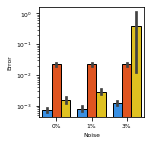

In [11]:
fig,ax = plt.subplots(1, 1, figsize=(2.,2.))
ax = sns.barplot(x="Noise", y="Error", data=df_plot, hue="Method", hue_order=['Inverse', 'Direct', 'Indirect'], palette=[color_inverse, color_direct, color_indirect], linewidth=.75)
ax.get_legend().remove()
plt.setp(ax.patches, linewidth=1, edgecolor='k')
plt.tight_layout()
plt.yscale('log')
plt.savefig(f'gr_error_bar_graph_{profile}.png', dpi=300)

4.167in up to 7in

In [12]:
df_characterization_renamed = df_characterization.rename(columns={'Score': 'Error'})

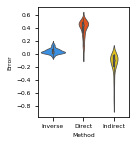

In [13]:
#violyn plot
columns = { 'Method':[], 'Error':[]}
dir_err_df = pd.DataFrame(columns)
inv_err_df = pd.DataFrame(columns)
indir_err_df = pd.DataFrame(columns)

dir_err_df['Error'] = dir_err
dir_err_df['Method'] = 'Direct'
inv_err_df['Error'] = inv_err
inv_err_df['Method'] = 'Inverse'
indir_err_df['Error'] = indir_err
indir_err_df['Method'] = 'Indirect'

error_df = pd.concat([inv_err_df, dir_err_df, indir_err_df], ignore_index=True)

fig,ax = plt.subplots(1, 1, figsize=(1.872,2.))
ax = sns.violinplot(x="Method", y="Error", data=error_df, palette=[color_inverse, color_direct, color_indirect], linewidth=.75 )

plt.tight_layout()
plt.savefig(f'gr_violyn_{profile}', dpi=300)

In [14]:
df_characterization_renamed 

,Profile,nsr,eps,Iteration,Method,Metric,Error,Data_true_profile,Data_method_profile
0,gompertz,0.000,0.000000,0,Indirect,MSE,0.000883,"[0.0009128047, 0.0023242143, 0.0053094605, 0.0...","[-0.0592800135, -0.035506848800000004, -0.0111..."
1,gompertz,0.000,0.000000,0,Direct,MSE,0.028990,"[0.0009128047, 0.0023242143, 0.0053094605, 0.0...","[0.4925613552, 0.4925589882, 0.492551744900000..."
2,gompertz,0.000,0.016681,0,Gaussian,MSE,0.000935,"[0.0009128047, 0.0023242143, 0.0053094605, 0.0...","[0.0320201112, 0.0433630156, 0.0576644528, 0.0..."
3,gompertz,0.000,0.000000,1,Indirect,MSE,0.000570,"[0.0020097129, 0.0043223648, 0.0085582434, 0.0...","[-0.052146386, -0.0289146557, -0.0051937311000..."
4,gompertz,0.000,0.000000,1,Direct,MSE,0.025136,"[0.0020097129, 0.0043223648, 0.0085582434, 0.0...","[0.4763400848, 0.4763381995, 0.476332394000000..."
...,...,...,...,...,...,...,...,...,...
2095,gompertz,0.001,0.000000,98,Direct,MSE,0.028616,"[0.003503103, 0.008432703, 0.0180831319, 0.035...","[0.4861847071, 0.4861802894, 0.4861707455, 0.4..."
2096,gompertz,0.001,0.016681,98,Gaussian,MSE,0.002156,"[0.003503103, 0.008432703, 0.0180831319, 0.035...","[0.0679395909, 0.0926066086, 0.1225345349, 0.1..."
2097,gompertz,0.001,0.000000,99,Indirect,MSE,0.070156,"[0.0130362432, 0.025665183100000002, 0.0462303...","[-1.1684148828, -1.2229167142, -1.1884123559, ..."
2098,gompertz,0.001,0.000000,99,Direct,MSE,0.023910,"[0.0130362432, 0.025665183100000002, 0.0462303...","[0.4703790249, 0.4703752283, 0.4703660793, 0.4..."


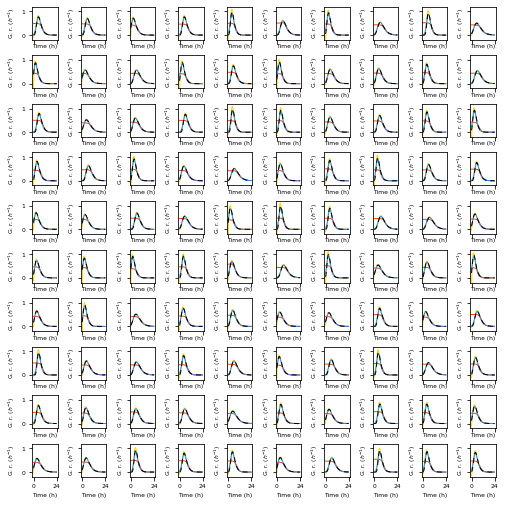

In [23]:
#por alguna razon los ejes x e y no calzan
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(10, 10, figsize=(7,7), sharex=True, sharey=True)
its = np.arange(100)
for ax,it in zip(axs.ravel(), its):
    gaussian= df_characterization_renamed[(df_characterization_renamed.Method=='Gaussian')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==0)]
    gaussian = gaussian.sort_values('Iteration')
    iteration = gaussian.Iteration.values[it] # np.random.randint(10)
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df_characterization_renamed[(df_characterization_renamed.Method=='Direct')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==0)]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    indirect = df_characterization_renamed[(df_characterization_renamed.Method=='Indirect')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==0)]
    indirect = indirect[indirect.Iteration==iteration]
    indirect_profile = indirect.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], indirect_profile, linewidth=1, color=color_indirect)
    ax.plot(t[:-1], direct_profile, linewidth=1, color=color_direct)
    ax.plot(t[:-1], gaussian_profile, linewidth=1, color=color_inverse)
    ax.plot(t[:-1], gtrue_profile, 'k--', linewidth=1, dashes=(5,4))
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([-0.2,1.2])
    ax.set_xticks([0,24])
    ax.set_yticks([0,1])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('G. r. ($h^{-1}$)')
plt.tight_layout()
plt.savefig(f'gr_all_nsr_0_{profile}.png', dpi=300)

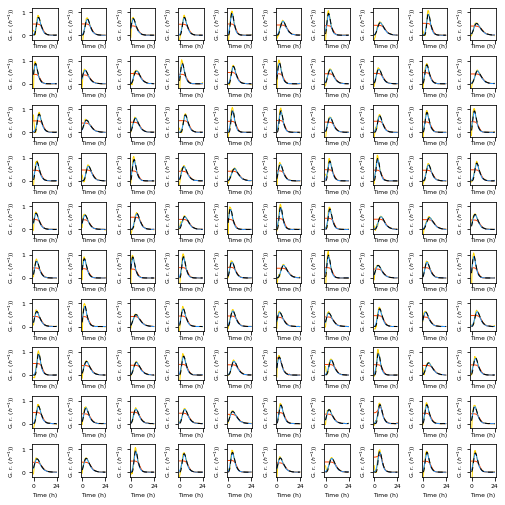

In [21]:
#por alguna razon los ejes x e y no calzan
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(10, 10, figsize=(7,7), sharex=True, sharey=True)
its = np.arange(100) #np.arange(4) #np.random.randint(10, size=(16,))
for ax,it in zip(axs.ravel(), its):
    gaussian= df_characterization_renamed[(df_characterization_renamed.Method=='Gaussian')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-4)]
    gaussian = gaussian.sort_values('Iteration')
    iteration = gaussian.Iteration.values[it] # np.random.randint(10)
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df_characterization_renamed[(df_characterization_renamed.Method=='Direct')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-4)]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    indirect = df_characterization_renamed[(df_characterization_renamed.Method=='Indirect')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-4)]
    indirect = indirect[indirect.Iteration==iteration]
    indirect_profile = indirect.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], indirect_profile, linewidth=1, color=color_indirect)
    ax.plot(t[:-1], direct_profile, linewidth=1, color=color_direct)
    ax.plot(t[:-1], gaussian_profile, linewidth=1, color=color_inverse)
    ax.plot(t[:-1], gtrue_profile, 'k--', linewidth=1, dashes=(5,4))
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([-0.2,1.2])
    ax.set_xticks([0,24])
    ax.set_yticks([0,1])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('G. r. ($h^{-1}$))')
plt.tight_layout()
plt.savefig(f'gr_all_nsr_01_{profile}.png', dpi=300)

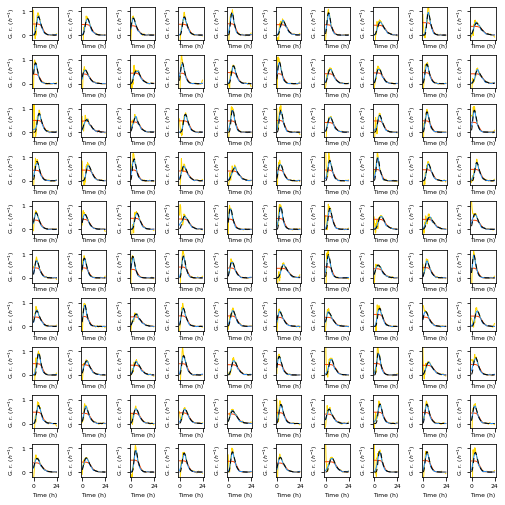

In [22]:
#por alguna razon los ejes x e y no calzan
t = np.linspace(0, 24, 100)
fig,axs = plt.subplots(10, 10, figsize=(7,7), sharex=True, sharey=True)
its = np.arange(100) #np.arange(4) #np.random.randint(10, size=(16,))
for ax,it in zip(axs.ravel(), its):
    gaussian= df_characterization_renamed[(df_characterization_renamed.Method=='Gaussian')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    gaussian = gaussian.sort_values('Iteration')
    iteration = gaussian.Iteration.values[it] # np.random.randint(10)
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df_characterization_renamed[(df_characterization_renamed.Method=='Direct')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    indirect = df_characterization_renamed[(df_characterization_renamed.Method=='Indirect')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    indirect = indirect[indirect.Iteration==iteration]
    indirect_profile = indirect.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], indirect_profile, linewidth=1, color=color_indirect)
    ax.plot(t[:-1], direct_profile, linewidth=1, color=color_direct)
    ax.plot(t[:-1], gaussian_profile, linewidth=1, color=color_inverse)
    ax.plot(t[:-1], gtrue_profile, 'k--', linewidth=1, dashes=(5,4))
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([-0.2,1.2])
    ax.set_xticks([0,24])
    ax.set_yticks([0,1])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('G. r. ($h^{-1}$)')
plt.tight_layout()
plt.savefig(f'gr_all_nsr_03_{profile}.png', dpi=300)

## Formatted exp plot

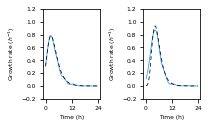

In [18]:
t = np.linspace(0, 24, 100)
samples = [6,-1] #16
fig,axs = plt.subplots(1, 2, figsize=(2.879,1.748), sharex=True, sharey=False)
#its = [8, 9] # np.random.randint(100, size=(2,)) #np.arange(4) #np.random.randint(10, size=(16,))
# choose criteria is 1 really noisy and one missing the peack
for ax,it in zip(axs.ravel(), samples): 
    gaussian= df_characterization_renamed[(df_characterization_renamed.Method=='Gaussian')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    gaussian = gaussian.sort_values('Error')
    iteration = gaussian.Iteration.values[it]
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    direct = df_characterization_renamed[(df_characterization_renamed.Method=='Direct')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    #direct = direct.sort_values('Error')
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    #ax.plot(t[:-1], direct_profile, linewidth=.75, color=color_direct)
    ax.plot(t[:-1], gaussian_profile, linewidth=.75, color=color_inverse)
    ax.plot(t[:-1], gtrue_profile, 'k--', linewidth=.75, dashes=(5, 4))
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([-0.2,1.2])
    ax.set_xticks([0,12,24])
    #ax.set_yticks([])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Growth rate ($h^{-1}$)')
plt.tight_layout()
#plt.savefig('gr_best_nsr_1e-3.png', dpi=300)
#plt.savefig('gr_all_nsr_0.png', dpi=300)
plt.savefig(f'gr_bwinv_ex%s_nsr_1e-3_{profile}_inverse.png'%it, dpi=300)

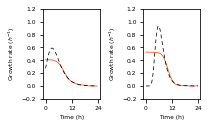

In [19]:
t = np.linspace(0, 24, 100)
samples = [0,-1] #16
fig,axs = plt.subplots(1, 2, figsize=(2.879,1.748), sharex=True, sharey=False)
#its = [8, 9] # np.random.randint(100, size=(2,)) #np.arange(4) #np.random.randint(10, size=(16,))
# choose criteria is 1 really noisy and one missing the peack
for ax,it in zip(axs.ravel(), samples): 
    direct = df_characterization_renamed[(df_characterization_renamed.Method=='Direct')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    direct = direct.sort_values('Error')
    iteration = direct.Iteration.values[it]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    gaussian= df_characterization_renamed[(df_characterization_renamed.Method=='Gaussian')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    #gaussian = gaussian.sort_values('Error')
    #iteration = gaussian.Iteration.values[it]
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], direct_profile, linewidth=.75, color=color_direct)
    #ax.plot(t[:-1], gaussian_profile, linewidth=.75, color=color_inverse)
    ax.plot(t[:-1], gtrue_profile, 'k--', linewidth=.75, dashes=(5, 4))
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([-0.2,1.2])
    ax.set_xticks([0,12,24])
    #ax.set_yticks([])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Growth rate ($h^{-1}$)')
plt.tight_layout()
#plt.savefig('gr_best_nsr_1e-3.png', dpi=300)
#plt.savefig('gr_all_nsr_0.png', dpi=300)
plt.savefig(f'gr_bwdir_ex%s_nsr_1e-3_{profile}_direct.png'%it, dpi=300)

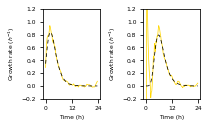

In [20]:
t = np.linspace(0, 24, 100)
samples = [0,-1] #16
fig,axs = plt.subplots(1, 2, figsize=(2.879,1.748), sharex=True, sharey=False)
#its = [8, 9] # np.random.randint(100, size=(2,)) #np.arange(4) #np.random.randint(10, size=(16,))
# choose criteria is 1 really noisy and one missing the peack
for ax,it in zip(axs.ravel(), samples): 
    direct = df_characterization_renamed[(df_characterization_renamed.Method=='Indirect')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    direct = direct.sort_values('Error')
    iteration = direct.Iteration.values[it]
    direct = direct[direct.Iteration==iteration]
    direct_profile = direct.Data_method_profile.values[0]

    gaussian= df_characterization_renamed[(df_characterization_renamed.Method=='Gaussian')&(df_characterization_renamed.Metric=='MSE')&(df_characterization_renamed.nsr==1e-3)]
    #gaussian = gaussian.sort_values('Error')
    #iteration = gaussian.Iteration.values[it]
    gaussian = gaussian[gaussian.Iteration==iteration]
    gaussian_profile = gaussian.Data_method_profile.values[0]
    
    

    gtrue_profile = gaussian.Data_true_profile.values[0]
    dtrue_profile = direct.Data_true_profile.values[0]

    ax.plot(t[:-1], direct_profile, linewidth=.75, color=color_indirect)
    #ax.plot(t[:-1], gaussian_profile, linewidth=.75, color=color_inverse)
    ax.plot(t[:-1], gtrue_profile, 'k--', linewidth=.75, dashes=(5, 4))
    #ax.plot(dtrue_profile, 'b--', linewidth=1)
    ax.set_ylim([-0.2,1.2])
    ax.set_xticks([0,12,24])
    #ax.set_yticks([])
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Growth rate ($h^{-1}$)')
plt.tight_layout()
#plt.savefig('gr_best_nsr_1e-3.png', dpi=300)
#plt.savefig('gr_all_nsr_0.png', dpi=300)
plt.savefig(f'gr_bwdir_ex%s_nsr_1e-3_{profile}_indirect.png'%it, dpi=300)